In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import properscoring as ps
import matplotlib.pyplot as plt
import datetime

In [2]:
import letkf_forecasting.letkf_io as letkf_io
import letkf_forecasting.tmh_plot as tmt_plot
import letkf_forecasting.analyse_results as analyse_results
import letkf_forecasting.prepare_sat_data as prepare_sat_data

In [83]:
import sklearn.calibration as calibration

In [3]:
%matplotlib inline

In [4]:
sensor_loc = pd.read_hdf('/home/travis/python_code/letkf_forecasting_other_things/data/sensor_loc.h5')

In [5]:
year = 2014
month = 5
day = 29
base_folder = '/a2/uaren/travis/'

In [6]:
truth = xr.open_dataset(f'{base_folder}data/{year:04}/{month:02}/{day:02}/data.nc')

truth = truth['ci']
truth = letkf_io.add_crop_attributes(truth)
truth_full = truth.copy()
truth = analyse_results.return_error_domain(truth)

In [7]:
truth = truth.clip(min=0, max=1)

In [8]:
ow_15 = letkf_io.return_day(year, month, day, 'ow_15', base_folder)
ow_15 = letkf_io.add_crop_attributes(ow_15)
ow_15 = letkf_io.add_crop_attributes(ow_15)

ow_15 = ow_15.clip(min=0, max=1)
ow_15_ed = analyse_results.return_error_domain(ow_15)
ow_15_30 = analyse_results.return_horizon(ow_15_ed, 30)

In [9]:
ow_15_wp3 = letkf_io.return_day(year, month, day, 'ow_15_wp3', base_folder)
ow_15_wp3 = letkf_io.add_crop_attributes(ow_15_wp3)
ow_15_wp3 = letkf_io.add_crop_attributes(ow_15_wp3)

ow_15_wp3 = ow_15_wp3.clip(min=0, max=1)
ow_15_wp3_ed = analyse_results.return_error_domain(ow_15_wp3)
ow_15_wp3_30 = analyse_results.return_horizon(ow_15_wp3_ed, 30)

In [10]:
persistence = truth.copy()
persistence['time'] = persistence.time + pd.Timedelta('30min')

In [23]:
climatology = pd.read_hdf('/home2/travis/data/satellite_data/cloudiness_index.h5')
climatology = climatology.values.ravel()
climatology = climatology[~np.isnan(climatology)]
climatology = climatology.clip(min=0, max=1)

In [166]:
climatology_day = truth.values.ravel()
climatology_day = climatology_day[~np.isnan(climatology_day)]
climatology_day = climatology_day.clip(min=0, max=1)

# For "oasis location"

In [11]:
def round_25(x):
    return np.round(x*4)/4

In [12]:
x_oasis, y_oasis = prepare_sat_data.sphere_to_lcc(sensor_loc['lat'].loc[18], sensor_loc['lon'].loc[18])
x_oasis = round_25(x_oasis)
y_oasis = round_25(y_oasis)

In [13]:
ow_15_oasis = ow_15_30['ci'].sel(south_north=y_oasis, west_east=x_oasis)
ow_15_wp3_oasis = ow_15_wp3_30['ci'].sel(south_north=y_oasis, west_east=x_oasis)
truth_oasis = truth.sel(south_north=y_oasis, west_east=x_oasis)

In [14]:
error_times = np.intersect1d(truth_oasis.time.to_pandas(), ow_15_oasis.time.to_pandas())

In [15]:
ow_15_oasis = ow_15_oasis.sel(time=error_times)
ow_15_wp3_oasis = ow_15_wp3_oasis.sel(time=error_times)
truth_oasis = truth_oasis.sel(time=error_times)

In [137]:
persistence = persistence.sel(time=error_times)

In [138]:
persis_array = persistence.values

persis_shape = persis_array.shape

persis_array = persis_array.reshape([persis_shape[0], persis_shape[1]*persis_shape[2]])

In [17]:
ow_15_oasis_mean = ow_15_oasis.mean(dim='ensemble_number')
ow_15_oasis_std = ow_15_oasis.var(dim='ensemble_number')
ow_15_wp3_oasis_mean = ow_15_wp3_oasis.mean(dim='ensemble_number')
ow_15_wp3_oasis_std = ow_15_wp3_oasis.var(dim='ensemble_number')

In [32]:
persistence_mean = persis_ens.mean(axis=-1)
persistence_std = persis_ens.var(axis=-1)

In [143]:
climatology.

(16, 20)

In [172]:
ens_members = 100
clim_weights, bin_edges = np.histogram(climatology, bins=ens_members, range=(0, 1), normed=True)
clim_ens = (bin_edges[:-1] + bin_edges[1:])/2
clim_ens = np.repeat(clim_ens[None, :], error_times.size, axis=0)
clim_weights = np.repeat(clim_weights[None, :], error_times.size, axis=0)

In [174]:
ens_members = 100
clim_day_weights, bin_edges = np.histogram(climatology_day, bins=ens_members, range=(0, 1), normed=True)
clim_day_ens = (bin_edges[:-1] + bin_edges[1:])/2
clim_day_ens = np.repeat(clim_day_ens[None, :], error_times.size, axis=0)
clim_day_weights = np.repeat(clim_day_weights[None, :], error_times.size, axis=0)

In [150]:
ens_members = 100
persis_weights = np.ones([error_times.size, ens_members])
for ii in range(error_times.size):#range(persis_ens.shape[0]):
    persis_weights[ii], bin_edges = np.histogram(persis_array[ii], bins=ens_members, range=(0, 1), normed=True)
persis_ens = (bin_edges[:-1] + bin_edges[1:])/2
persis_ens = np.repeat(persis_ens[None, :], error_times.size, axis=0)

In [125]:
# bins = 50
# persis_cdf = np.ones([persis_ens.shape[0], bins])
# for ii in range(persis_ens.shape[0]):#range(persis_ens.shape[0]):
#     persis_cdf[ii], bin_edges = np.histogram(persis_ens[ii], bins=bins, range=(0, 1), normed=True)
#     persis_cdf[ii] = np.cumsum(persis_cdf[ii])*(bin_edges[1] - bin_edges[0])
# persis_cdf = persis_cdf.clip(min=0, max=1)

In [208]:
persistence.sel(west_east=x_oasis, south_north=y_oasis).values

array([ 0.92045383,  0.90401888,  0.93009666,  0.79881374,  0.66233177,
        0.72894962,  0.88367382,  1.        ,  0.95060286,  0.94372847,
        0.82970527,  0.93696874,  0.96495314,  0.67885022,  0.15079273,
        0.10271777])

In [209]:
persis_crps = ps.crps_ensemble(truth_oasis.values, persistence.sel(west_east=x_oasis, south_north=y_oasis).values)

In [211]:
persis_crps.mean()

0.13848048670052276

In [154]:
persis_crps_ens = ps.crps_ensemble(truth_oasis.values, persis_ens, weights=persis_weights)

In [177]:
clim_crps_ens = ps.crps_ensemble(truth_oasis.values, clim_ens, weights=clim_weights)
clim_day_crps_ens = ps.crps_ensemble(truth_oasis.values, clim_day_ens, weights=clim_day_weights)

In [23]:
ow_15_crps_ens = ps.crps_ensemble(truth_oasis.values, ow_15_oasis.values)
ow_15_wp3_crps_ens = ps.crps_ensemble(truth_oasis.values, ow_15_wp3_oasis.values)

In [155]:
print('ow_15 ens crps: ', ow_15_crps_ens.mean())
print('ow_15_wp3 ens crps: ', ow_15_wp3_crps_ens.mean())

ow_15 ens crps:  0.0723067103995
ow_15_wp3 ens crps:  0.0698236420234


In [178]:
print('persistence ens crps: ', persis_crps_ens.mean())
print('Climatology ens crps: ', clim_crps_ens.mean())
print('Climatology day ens crps: ', clim_day_crps_ens.mean())

persistence ens crps:  0.089759460887
Climatology ens crps:  0.601188219425
Climatology day ens crps:  0.167672497919


In [179]:
print('ow_15 SS_RPS persis: ', 1 - ow_15_crps_ens.mean()/persis_crps_ens.mean())
print('ow_15_wp3 SS_RPS persis: ', 1 - ow_15_wp3_crps_ens.mean()/persis_crps_ens.mean())

ow_15 SS_RPS persis:  0.194439118897
ow_15_wp3 SS_RPS persis:  0.222102702786


In [180]:
print('ow_15 SS_RPS clim day: ', 1 - ow_15_crps_ens.mean()/clim_day_crps_ens.mean())
print('ow_15_wp3 SS_RPS clim day: ', 1 - ow_15_wp3_crps_ens.mean()/clim_day_crps_ens.mean())
print('persis SS_RPS clim day: ', 1 - persis_crps_ens.mean()/clim_day_crps_ens.mean())

ow_15 SS_RPS clim day:  0.568762252029
ow_15_wp3 SS_RPS clim day:  0.583571289926
persis SS_RPS clim day:  0.464673920883


In [181]:
print('ow_15 SS_RPS clim: ', 1 - ow_15_crps_ens.mean()/clim_crps_ens.mean())
print('ow_15_wp3 SS_RPS clim: ', 1 - ow_15_wp3_crps_ens.mean()/clim_crps_ens.mean())
print('persis SS_RPS clim: ', 1 - persis_crps_ens.mean()/clim_crps_ens.mean())

ow_15 SS_RPS clim:  0.879727000525
ow_15_wp3 SS_RPS clim:  0.883857268377
persis SS_RPS clim:  0.850696573907


In [ ]:
ow_15_crps_gauss = ps.crps_gaussian(truth_oasis.values, ow_15_oasis_mean, ow_15_oasis_std)
ow_15_wp3_crps_gauss = ps.crps_gaussian(truth_oasis.values, ow_15_wp3_oasis_mean, ow_15_wp3_oasis_std)

In [ ]:
persis_crps_gauss = ps.crps_gaussian(truth_oasis.values, persistence_mean, persistence_std)

In [ ]:
print('ow_15 gauss crps: ', ow_15_crps_gauss.mean())
print('ow_15_wp3 gauss crps: ', ow_15_wp3_crps_gauss.mean())

In [ ]:
print('persistence gauss crps: ', persis_crps_gauss.mean())

# For error domain many dates

In [444]:
month_day = [[5, 29], [6, 11], [6, 12]]
dates = []
for ii in range(len(month_day)):
    dates.append(datetime.date(2014, month_day[ii][0], month_day[ii][1]))
base_folder = '/a2/uaren/travis'

In [448]:
dates_truth = letkf_io.return_many_truths(dates, base_folder)
dates_truth = dates_truth['ci']
dates_truth = letkf_io.add_crop_attributes(dates_truth)
dates_truth = analyse_results.return_error_domain(dates_truth)

In [446]:
dates_15 = letkf_io.return_many_days(dates, 'ow_15', base_folder)
dates_15 = dates_15['ci']
dates_15 = letkf_io.add_crop_attributes(dates_15)
dates_15 = analyse_results.return_error_domain(dates_15)
dates_15 = analyse_results.return_horizon(dates_15, 30)

In [458]:
dates_wp = letkf_io.return_many_days(dates, 'ow_15_wp3', base_folder)
dates_wp = dates_wp['ci']
dates_wp = letkf_io.add_crop_attributes(dates_wp)
dates_wp = analyse_results.return_error_domain(dates_wp)
dates_wp = analyse_results.return_horizon(dates_wp, 30)

In [453]:
dates_error_times = np.intersect1d(dates_truth.time.to_pandas(), 
                                   dates_15.time.to_pandas())

In [457]:
crps_15_30 = ps.crps_ensemble(dates_truth.sel(time=dates_error_times).values,
                              dates_15.sel(time=dates_error_times).values.transpose([0, 2, 3, 1]))

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [459]:
crps_wp_30 = ps.crps_ensemble(dates_truth.sel(time=dates_error_times).values,
                              dates_wp.sel(time=dates_error_times).values.transpose([0, 2, 3, 1]))

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [461]:
print(crps_15_30.mean())

0.105026868319


In [462]:
print(crps_wp_30.mean())

0.0931038704697


# For "oasis location" many Dates

In [5]:
month_day = [[4, 9], [4, 15], [4, 18], [5, 6], [5, 9], [5, 29], [6, 11], [6, 12]]
dates = []
for ii in range(len(month_day)):
    dates.append(datetime.date(2014, month_day[ii][0], month_day[ii][1]))
base_folder = '/a2/uaren/travis'

In [6]:
def round_25(x):
    return np.round(x*4)/4

In [7]:
x_oasis, y_oasis = prepare_sat_data.sphere_to_lcc(sensor_loc['lat'].loc[18], sensor_loc['lon'].loc[18])
x_oasis = round_25(x_oasis)
y_oasis = round_25(y_oasis)

In [9]:
dates_truth = letkf_io.return_many_truths(dates, base_folder)
dates_truth = dates_truth['ci']
dates_truth = letkf_io.add_crop_attributes(dates_truth)
dates_truth = analyse_results.return_error_domain(dates_truth)

In [10]:
dates_15 = letkf_io.return_many_days(dates, 'ow_15', base_folder)
dates_15 = dates_15['ci'].sel(south_north=y_oasis, west_east=x_oasis)
# dates_15 = letkf_io.add_crop_attributes(dates_15)
# dates_15 = analyse_results.return_error_domain(dates_15)
dates_15 = analyse_results.return_horizon(dates_15, 30)

In [11]:
dates_wp = letkf_io.return_many_days(dates, 'ow_15_wp3', base_folder)
dates_wp = dates_wp['ci'].sel(south_north=y_oasis, west_east=x_oasis)
# dates_wp = letkf_io.add_crop_attributes(dates_wp)
# dates_wp = analyse_results.return_error_domain(dates_wp)
dates_wp = analyse_results.return_horizon(dates_wp, 30)

In [12]:
# ow_15_oasis = dates_15.sel(south_north=y_oasis, west_east=x_oasis)
# ow_15_wp3_oasis = dates_wp.sel(south_north=y_oasis, west_east=x_oasis)
ow_15_oasis = dates_15.copy()
ow_15_wp3_oasis = dates_wp.copy()
truth_oasis = dates_truth.sel(south_north=y_oasis, west_east=x_oasis)

In [13]:
error_times = np.intersect1d(truth_oasis.time.to_pandas(), ow_15_oasis.time.to_pandas())

In [14]:
ow_15_oasis = ow_15_oasis.sel(time=error_times)
ow_15_wp3_oasis = ow_15_wp3_oasis.sel(time=error_times)
truth_oasis = truth_oasis.sel(time=error_times)

In [15]:
persistence = dates_truth.copy()
persistence['time'] = persistence.time + pd.Timedelta('30min')

In [16]:
persistence = persistence.sel(time=error_times)

In [24]:
persis_array = persistence.values

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [25]:
persis_shape = persis_array.shape

In [26]:
persis_array = persis_array.reshape([persis_shape[0], persis_shape[1]*persis_shape[2]])

In [27]:
climatology_dates = dates_truth.values.ravel()
climatology_dates = climatology_dates[~np.isnan(climatology_dates)]
climatology_dates = climatology_dates.clip(min=0, max=1)

In [28]:
ens_members = 100
clim_weights, bin_edges = np.histogram(climatology, bins=ens_members, range=(0, 1), normed=True)
clim_ens = (bin_edges[:-1] + bin_edges[1:])/2
clim_ens = np.repeat(clim_ens[None, :], error_times.size, axis=0)
clim_weights = np.repeat(clim_weights[None, :], error_times.size, axis=0)

In [29]:
ens_members = 100
clim_day_weights, bin_edges = np.histogram(climatology_dates, bins=ens_members, range=(0, 1), normed=True)
clim_day_ens = (bin_edges[:-1] + bin_edges[1:])/2
clim_day_ens = np.repeat(clim_day_ens[None, :], error_times.size, axis=0)
clim_day_weights = np.repeat(clim_day_weights[None, :], error_times.size, axis=0)

In [30]:
ens_members = 100
persis_weights = np.ones([error_times.size, ens_members])
for ii in range(error_times.size):#range(persis_ens.shape[0]):
    persis_weights[ii], bin_edges = np.histogram(persis_array[ii], bins=ens_members, range=(0, 1), normed=True)
persis_ens = (bin_edges[:-1] + bin_edges[1:])/2
persis_ens = np.repeat(persis_ens[None, :], error_times.size, axis=0)

In [ ]:
# bins = 50
# persis_cdf = np.ones([persis_ens.shape[0], bins])
# for ii in range(persis_ens.shape[0]):#range(persis_ens.shape[0]):
#     persis_cdf[ii], bin_edges = np.histogram(persis_ens[ii], bins=bins, range=(0, 1), normed=True)
#     persis_cdf[ii] = np.cumsum(persis_cdf[ii])*(bin_edges[1] - bin_edges[0])
# persis_cdf = persis_cdf.clip(min=0, max=1)

In [31]:
persis_crps = ps.crps_ensemble(truth_oasis.values, persistence.sel(west_east=x_oasis, south_north=y_oasis).values)

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [32]:
persis_crps.mean()

0.1009778883283011

In [33]:
persis_crps_ens = ps.crps_ensemble(truth_oasis.values, persis_ens, weights=persis_weights)

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [34]:
clim_crps_ens = ps.crps_ensemble(truth_oasis.values, clim_ens, weights=clim_weights)
clim_day_crps_ens = ps.crps_ensemble(truth_oasis.values, clim_day_ens, weights=clim_day_weights)

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [35]:
ow_15_crps_ens = ps.crps_ensemble(truth_oasis.values, ow_15_oasis.values)
ow_15_wp3_crps_ens = ps.crps_ensemble(truth_oasis.values, ow_15_wp3_oasis.values)

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [36]:
print('ow_15 crps: ', ow_15_crps_ens.mean())
print('ow_15_wp3 crps: ', ow_15_wp3_crps_ens.mean())

ow_15 crps:  0.0581506044007
ow_15_wp3 crps:  0.0599899912061


In [37]:
print('Persistent dist crps: ', persis_crps_ens.mean())
print('Climatology crps: ', clim_crps_ens.mean())
print('Climatology dates crps: ', clim_day_crps_ens.mean())

Persistent dist crps:  0.0624119070422
Climatology crps:  0.234126173564
Climatology dates crps:  0.180587048336


In [38]:
print('ow_15 SS_RPS persis: ', 1 - ow_15_crps_ens.mean()/persis_crps.mean())
print('ow_15_wp3 SS_RPS persis: ', 1 - ow_15_wp3_crps_ens.mean()/persis_crps.mean())

ow_15 SS_RPS persis:  0.424125366817
ow_15_wp3 SS_RPS persis:  0.405909628343


In [39]:
print('ow_15 SS_RPS persis dist: ', 1 - ow_15_crps_ens.mean()/persis_crps_ens.mean())
print('ow_15_wp3 SS_RPS persis dist: ', 1 - ow_15_wp3_crps_ens.mean()/persis_crps_ens.mean())

ow_15 SS_RPS persis dist:  0.0682770779403
ow_15_wp3 SS_RPS persis dist:  0.0388053490256


In [40]:
print('ow_15 SS_RPS clim day: ', 1 - ow_15_crps_ens.mean()/clim_day_crps_ens.mean())
print('ow_15_wp3 SS_RPS clim day: ', 1 - ow_15_wp3_crps_ens.mean()/clim_day_crps_ens.mean())
print('persis SS_RPS clim day: ', 1 - persis_crps_ens.mean()/clim_day_crps_ens.mean())

ow_15 SS_RPS clim day:  0.67799127935
ow_15_wp3 SS_RPS clim day:  0.667805682862
persis SS_RPS clim day:  0.654394334382


In [41]:
print('ow_15 SS_RPS clim: ', 1 - ow_15_crps_ens.mean()/clim_crps_ens.mean())
print('ow_15_wp3 SS_RPS clim: ', 1 - ow_15_wp3_crps_ens.mean()/clim_crps_ens.mean())
print('persis SS_RPS clim: ', 1 - persis_crps_ens.mean()/clim_crps_ens.mean())

ow_15 SS_RPS clim:  0.751627067083
ow_15_wp3 SS_RPS clim:  0.743770675902
persis SS_RPS clim:  0.733426186009


# Reliability diagram many dates oasis location

In [17]:
thin_ub = 0.4

In [18]:
truth_thick = (truth_oasis.sel(time=error_times)>thin_ub).astype('float')

In [19]:
persistence_thick = (persistence.sel(time=error_times)>thin_ub).astype('float')

In [55]:
persistence_thick = persistence_thick.sel(south_north=y_oasis, west_east=x_oasis)

In [64]:
truth_thick = truth_thick.load()
persistence_thick = persistence_thick.load()

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [75]:
persistence_dist_thick = (persistence.sel(time=error_times)>thin_ub).astype('float')
persistence_dist_thick = persistence_dist_thick.mean(dim=['west_east', 'south_north'])

In [78]:
persistence_dist_thick = persistence_dist_thick.load()

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [ ]:
# ow_15_thick = (ow_15_30['ci'].sel(time=error_times)>thin_ub).astype('int')
# ow_15_thick = ow_15_thick.mean(dim='ensemble_number')

In [57]:
ow_15_thick = (ow_15_oasis.sel(time=error_times)>thin_ub).astype('int')
ow_15_thick = ow_15_thick.mean(dim='ensemble_number')

In [58]:
ow_15_wp3_thick = (ow_15_wp3_oasis.sel(time=error_times)>thin_ub).astype('int')
ow_15_wp3_thick = ow_15_wp3_thick.mean(dim='ensemble_number')

In [65]:
ow_15_thick = ow_15_thick.load()
ow_15_wp3_thick = ow_15_wp3_thick.load()

In [ ]:
# ow_15_wp3_thick = (ow_15_wp3_30['ci'].sel(time=error_times)>thin_ub).astype('int')
# ow_15_wp3_thick = ow_15_wp3_thick.mean(dim='ensemble_number')

In [67]:
this = ps.brier_score(truth_thick.values.ravel(), ow_15_wp3_thick.values.ravel()).mean()
print('wp brier score: ', this)

wp brier score:  0.0384057971014


In [68]:
this = ps.brier_score(truth_thick.values.ravel(), ow_15_thick.values.ravel()).mean()
print('ow_15 brier score: ', this)

ow_15 brier score:  0.0401449275362


In [80]:
this = ps.brier_score(truth_thick.values.ravel(), persistence_dist_thick.values.ravel()).mean()
print('persistent distribution brier score: ', this)

persistent distribution brier score:  0.0359777531948


In [70]:
this = ps.brier_score(truth_thick.values.ravel(), persistence_thick.values.ravel()).mean()
print('persistence brier score: ', this)

persistence brier score:  0.0579710144928


In [ ]:
fraction_of_positives, mean_predicted_value = \
    calibration_curve(truth_thick.values.ravel(),
                      ow_15_thick.values.ravel(), n_bins=5)

In [81]:
%matplotlib notebook

<IPython.core.display.Javascript object>


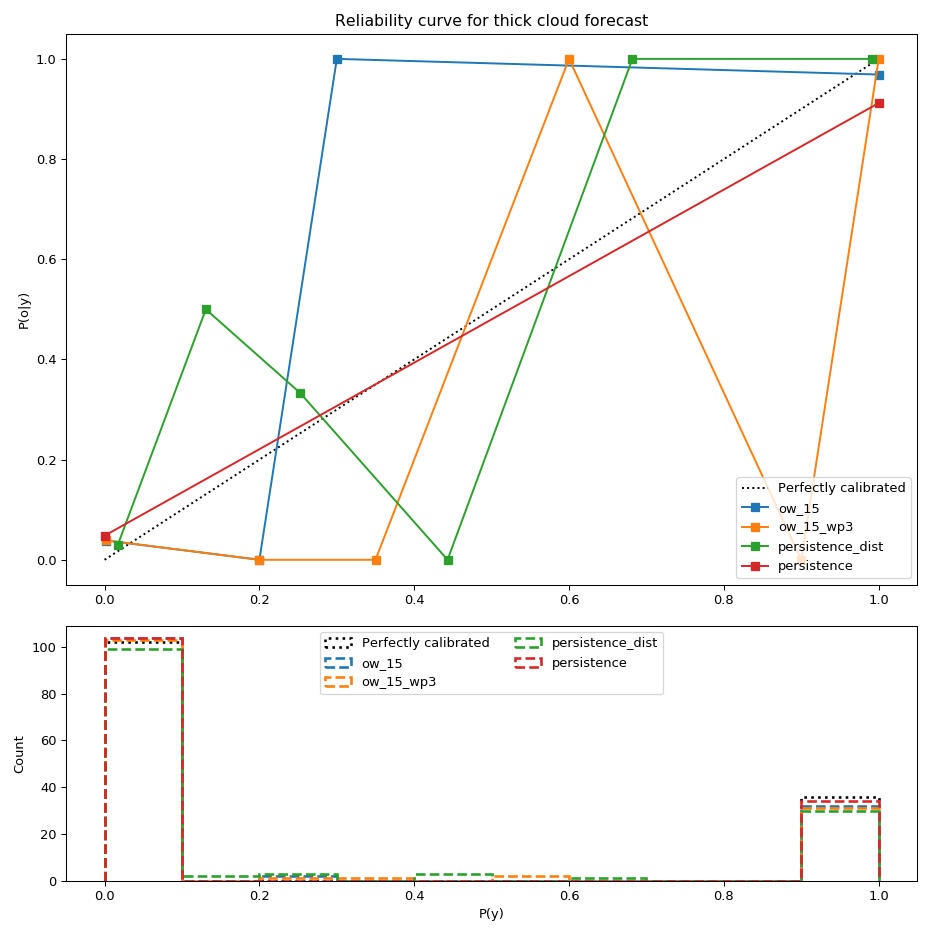

In [84]:
fig_index = 1
num_of_bins = 10
fig = plt.figure(fig_index, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax2.hist(truth_thick.values.ravel(), color='k', linestyle=':', range=(0, 1), bins=num_of_bins, label="Perfectly calibrated",
         histtype="step", lw=2)
for forecast, name in [(ow_15_thick, 'ow_15'),
                       (ow_15_wp3_thick, 'ow_15_wp3'),
                       (persistence_dist_thick, 'persistence_dist'),
                       (persistence_thick, 'persistence')]:
    
    fraction_of_positives, mean_predicted_value = \
        calibration.calibration_curve(truth_thick.values.ravel(),
                                      forecast.values.ravel(), n_bins=num_of_bins)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label=f'{name}')
    ax2.hist(forecast.values.ravel(), range=(0, 1), bins=num_of_bins, label=name,
             histtype="step", lw=2, linestyle='--')


ax1.set_ylabel("P(o|y)")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability curve for thick cloud forecast')

ax2.set_xlabel("P(y)")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

# Reliability diagram one day

In [383]:
thin_ub = 0.4

In [384]:
truth_thick = (truth.sel(time=error_times)>thin_ub).astype('float')

In [385]:
persistence_thick = (persistence.sel(time=error_times)>thin_ub).astype('float')

In [386]:
persistence_dist_thick = persistence_thick.copy()

In [387]:
for ii in range(error_times.size):
    persistence_dist_thick[ii] = persistence_dist_thick[ii].mean(dim=['west_east', 'south_north']).item()

In [388]:
ow_15_thick = (ow_15_30['ci'].sel(time=error_times)>thin_ub).astype('int')
ow_15_thick = ow_15_thick.mean(dim='ensemble_number')

In [389]:
ow_15_wp3_thick = (ow_15_wp3_30['ci'].sel(time=error_times)>thin_ub).astype('int')
ow_15_wp3_thick = ow_15_wp3_thick.mean(dim='ensemble_number')

In [390]:
this = ps.brier_score(truth_thick.values.ravel(), ow_15_wp3_thick.values.ravel()).mean()
print(this)

0.0732383065908


In [391]:
this = ps.brier_score(truth_thick.values.ravel(), ow_15_thick.values.ravel()).mean()
print(this)

0.0821671152519


In [392]:
this = ps.brier_score(truth_thick.values.ravel(), persistence_dist_thick.values.ravel()).mean()
print(this)

0.0992428213742


In [393]:
this = ps.brier_score(truth_thick.values.ravel(), persistence_thick.values.ravel()).mean()
print(this)

0.0937612146308


In [394]:
fraction_of_positives, mean_predicted_value = \
    calibration_curve(truth_thick.values.ravel(),
                      ow_15_thick.values.ravel(), n_bins=5)

In [395]:
fraction_of_positives

array([ 0.22404229,  0.67315716,  0.70360169,  0.74079975,  0.95731191])

In [396]:
mean_predicted_value

array([ 0.00805989,  0.32312736,  0.52488347,  0.73219691,  0.9978851 ])

In [413]:
%matplotlib notebook

<IPython.core.display.Javascript object>


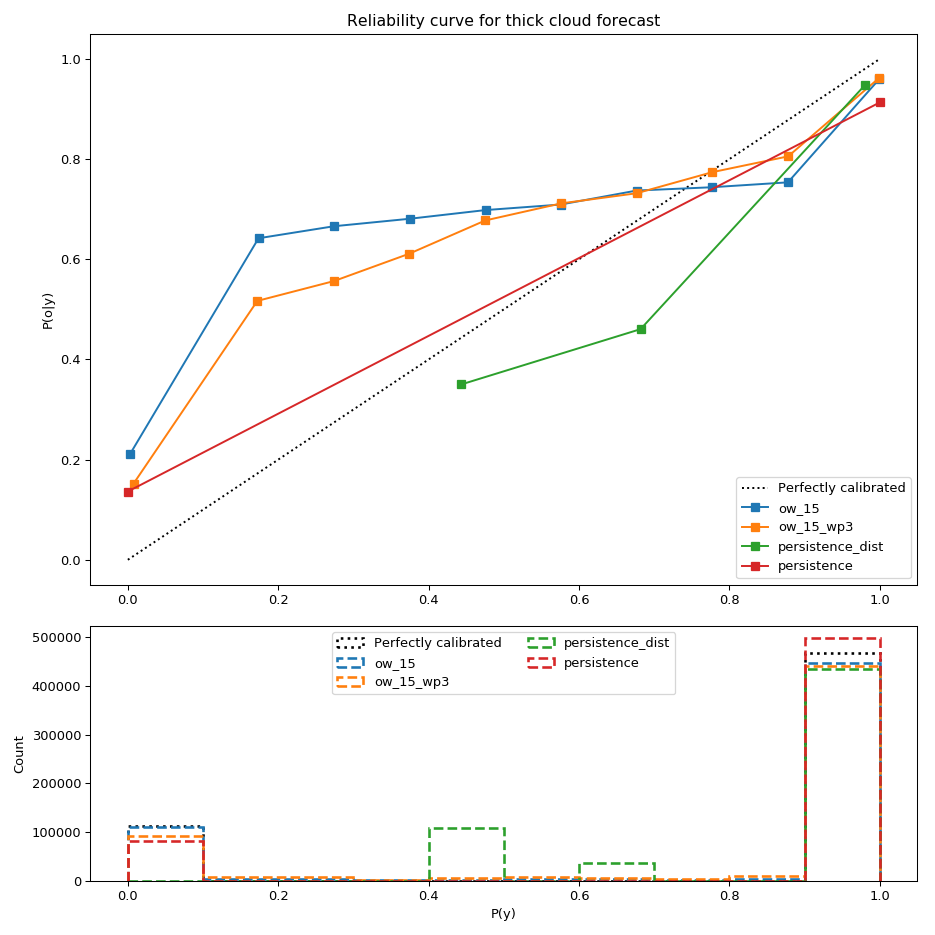

In [415]:
fig_index = 1
num_of_bins = 10
fig = plt.figure(fig_index, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax2.hist(truth_thick.values.ravel(), color='k', linestyle=':', range=(0, 1), bins=num_of_bins, label="Perfectly calibrated",
         histtype="step", lw=2)
for forecast, name in [(ow_15_thick, 'ow_15'),
                       (ow_15_wp3_thick, 'ow_15_wp3'),
                       (persistence_dist_thick, 'persistence_dist'),
                       (persistence_thick, 'persistence')]:
    
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(truth_thick.values.ravel(),
                          forecast.values.ravel(), n_bins=num_of_bins)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label=f'{name}')
    ax2.hist(forecast.values.ravel(), range=(0, 1), bins=num_of_bins, label=name,
             histtype="step", lw=2, linestyle='--')


ax1.set_ylabel("P(o|y)")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability curve for thick cloud forecast')

ax2.set_xlabel("P(y)")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [417]:
clear_ub = 0.05

In [418]:
truth_clear = (truth.sel(time=error_times)<clear_ub).astype('float')

In [419]:
persistence_clear = (persistence.sel(time=error_times)<clear_ub).astype('float')

In [420]:
persistence_dist_clear = persistence_clear.copy()

In [421]:
for ii in range(error_times.size):
    persistence_dist_clear[ii] = persistence_dist_clear[ii].mean(dim=['west_east', 'south_north']).item()

In [422]:
ow_15_clear = (ow_15_30['ci'].sel(time=error_times)<clear_ub).astype('int')
ow_15_clear = ow_15_clear.mean(dim='ensemble_number')

In [423]:
ow_15_wp3_clear = (ow_15_wp3_30['ci'].sel(time=error_times)<clear_ub).astype('int')
ow_15_wp3_clear = ow_15_wp3_clear.mean(dim='ensemble_number')

In [424]:
this = ps.brier_score(truth_clear.values.ravel(), ow_15_wp3_clear.values.ravel()).mean()
print(this)

0.0314223343685


In [425]:
this = ps.brier_score(truth_clear.values.ravel(), ow_15_clear.values.ravel()).mean()
print(this)

0.0364378752588


In [426]:
this = ps.brier_score(truth_clear.values.ravel(), persistence_dist_clear.values.ravel()).mean()
print(this)

0.0647009057435


In [427]:
this = ps.brier_score(truth_clear.values.ravel(), persistence_clear.values.ravel()).mean()
print(this)

0.0474603174603


In [428]:
%matplotlib notebook

<IPython.core.display.Javascript object>


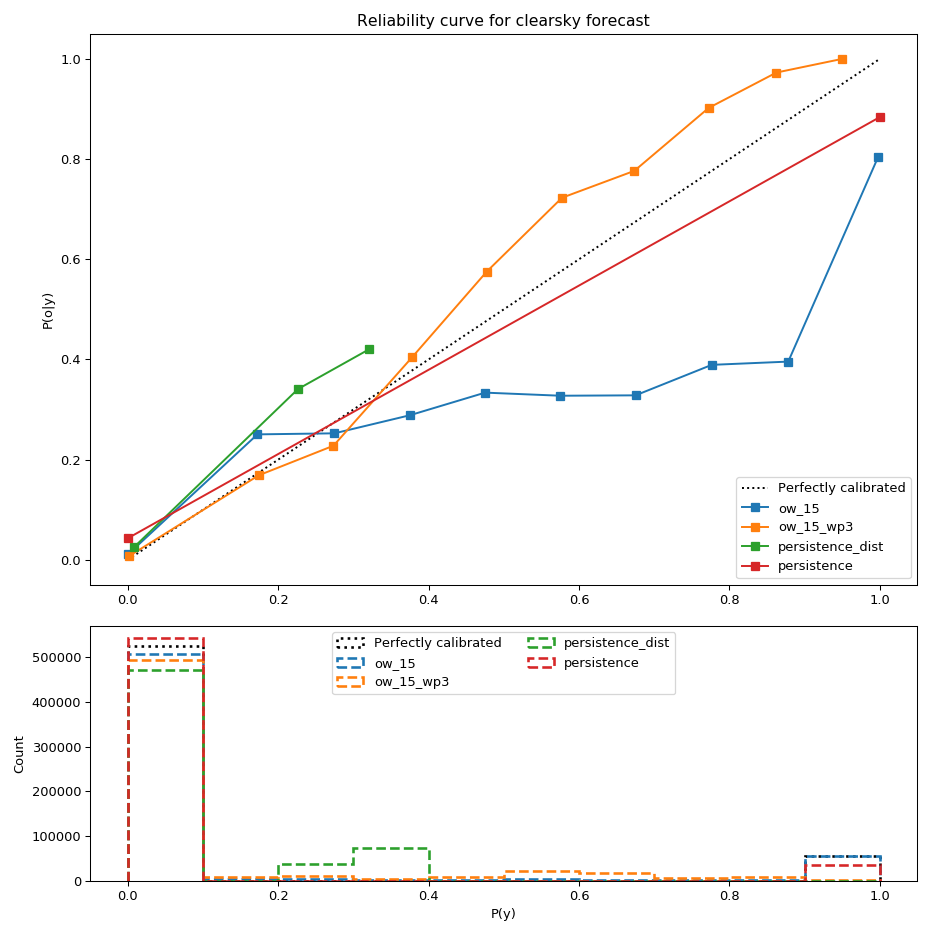

In [430]:
fig_index = 1
num_of_bins = 10
fig = plt.figure(fig_index, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax2.hist(truth_clear.values.ravel(), color='k', linestyle=':', range=(0, 1), bins=num_of_bins, label="Perfectly calibrated",
         histtype="step", lw=2)
for forecast, name in [(ow_15_clear, 'ow_15'),
                       (ow_15_wp3_clear, 'ow_15_wp3'),
                       (persistence_dist_clear, 'persistence_dist'),
                       (persistence_clear, 'persistence')]:
    
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(truth_clear.values.ravel(),
                          forecast.values.ravel(), n_bins=num_of_bins)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label=f'{name}')
    ax2.hist(forecast.values.ravel(), range=(0, 1), bins=num_of_bins, label=name,
             histtype="step", lw=2, linestyle='--')


ax1.set_ylabel("P(o|y)")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Reliability curve for clearsky forecast')

ax2.set_xlabel("P(y)")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()